---
title: "Palmer Penguins Modeling 8.2"
format: 
  html:
    embed-resources: true
execute:
  echo: true
code-fold: true
author: James Compagno
jupyter: python3
---

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [50]:
import numpy as np
import pandas as pd
from palmerpenguins import load_penguins
import plotnine as p9
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [51]:
# Read the data
penguins = load_penguins()
penguins = penguins.dropna()

# Separate X and Y
y = penguins['species']
X = penguins.drop(columns=['species'])

# Train/test split on
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67, stratify=y)

# Model Library 
model_library = {}
records = []

In [52]:
print(penguins.head())

  species     island  bill_length_mm  ...  body_mass_g     sex  year
0  Adelie  Torgersen            39.1  ...       3750.0    male  2007
1  Adelie  Torgersen            39.5  ...       3800.0  female  2007
2  Adelie  Torgersen            40.3  ...       3250.0  female  2007
4  Adelie  Torgersen            36.7  ...       3450.0  female  2007
5  Adelie  Torgersen            39.3  ...       3650.0    male  2007

[5 rows x 8 columns]


In [ ]:
# Column Transformer 
ct = ColumnTransformer(
    [
        ("standardize", 
         StandardScaler(), 
         make_column_selector(dtype_include=np.number)),
        ("encode",
         OneHotEncoder(drop='first', sparse_output=False),
         make_column_selector(dtype_include=object))
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [54]:
def run_knn_classification(model_name, k_value, features=None):
    """
    model_name - will be stored in model_library example: "KNN_All_5"
    k_value - number of neighbors - Example: 5, 10, 15
    features - list or None - Example: ['bill_length_mm', 'flipper_length_mm']
    """
    
    # Select features
    if features is not None:
        X_train_subset = X_train[features]
        X_test_subset = X_test[features]
    else:
        X_train_subset = X_train
        X_test_subset = X_test
    
    # Pipeline with KNN Classifier
    pipe = Pipeline([
        ("preprocess", ct),
        ("knn", KNeighborsClassifier(n_neighbors=k_value))
    ])
    
    # Fit and add to Library
    pipe.fit(X_train_subset, y_train)
    model_library[model_name] = pipe
    
    # Metrics Calculation 
    accuracy_cv = cross_val_score(pipe, X_train_subset, y_train, cv=5, scoring='accuracy')
    
    # Test Set Performance
    y_pred_test = pipe.predict(X_test_subset)
    y_pred_proba = pipe.predict_proba(X_test_subset)
    
    # Overall metrics
    test_accuracy = accuracy_score(y_test, y_pred_test)
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    
    # Precision, Recall, f1
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_test, average=None)
    
    # AUC 
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average=None)
    
    # Get class names
    classes = pipe.classes_
    
    # Metrics Storage 
    records.append({
        "Model": model_name,
        "Classification Type": "KNN",
        "Variables Used": len(X_train_subset.columns) if features else "All",
        "Hyperparameter 1 Name": "K (n_neighbors)", 
        "Hyperparameter 1 Value": k_value,
        "Hyperparameter 2 Name": "NA", 
        "Hyperparameter 2 Value": "NA",
        "Split": "CV-5",
        "Accuracy Mean (CV)": accuracy_cv.mean(),
        "Test Accuracy": test_accuracy,
        "Confusion Matrix": conf_matrix,
        "Precision by Class": dict(zip(classes, precision)),
        "Recall by Class": dict(zip(classes, recall)),
        "F1-Score by Class": dict(zip(classes, f1)),
        "AUC by Class": dict(zip(classes, auc))
    })
    
    # Print
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_test))
    print(f"Multi-class AUC (One-vs-Rest): {roc_auc_score(y_test, y_pred_proba, multi_class='ovr'):.4f}")
    print()

In [55]:
run_knn_classification("KNN_5", 5)

Confusion Matrix:
[[29  0  0]
 [ 0 14  0]
 [ 0  0 24]]

Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67

Multi-class AUC (One-vs-Rest): 1.0000



In [56]:
run_knn_classification("KNN_10", 10)

Confusion Matrix:
[[29  0  0]
 [ 0 14  0]
 [ 0  0 24]]

Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67

Multi-class AUC (One-vs-Rest): 1.0000



In [57]:
def run_decision_tree_classification(model_name, max_depth, features=None):
    """
    model_name - will be stored in model_library example: "DecisionTree_MaxDepth_5"
    max_depth - maximum depth of the tree - Example: 3, 5, 10
    features - list or None - Example: ['bill_length_mm', 'flipper_length_mm']
    
    """
    
    # Select features
    if features is not None:
        X_train_subset = X_train[features]
        X_test_subset = X_test[features]
    else:
        X_train_subset = X_train
        X_test_subset = X_test
    
    # Pipeline with Decision Tree Classifier
    pipe = Pipeline([
        ("preprocess", ct),
        ("decision_tree", DecisionTreeClassifier(max_depth=max_depth, random_state=67))
    ])
    
    # Fit and add to Library
    pipe.fit(X_train_subset, y_train)
    model_library[model_name] = pipe
    
    # Metrics Calculation
    accuracy_cv = cross_val_score(pipe, X_train_subset, y_train, cv=5, scoring='accuracy')
    
    # Test Set Performance
    y_pred_test = pipe.predict(X_test_subset)
    y_pred_proba = pipe.predict_proba(X_test_subset)
    
    # Overall metrics
    test_accuracy = accuracy_score(y_test, y_pred_test)
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    
    # Precision, Recall, f1
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_test, average=None)
    
    # AUC
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average=None)
    
    # Get class names
    classes = pipe.classes_
    
    # Metrics Storage 
    records.append({
        "Model": model_name,
        "Classification Type": "Decision Tree",
        "Variables Used": len(X_train_subset.columns) if features else "All",
        "Hyperparameter 1 Name": "Max Depth", 
        "Hyperparameter 1 Value": max_depth,
        "Hyperparameter 2 Name": "NA", 
        "Hyperparameter 2 Value": "NA",
        "Split": "CV-5",
        "Accuracy Mean (CV)": accuracy_cv.mean(),
        "Test Accuracy": test_accuracy,
        "Confusion Matrix": conf_matrix,
        "Precision by Class": dict(zip(classes, precision)),
        "Recall by Class": dict(zip(classes, recall)),
        "F1-Score by Class": dict(zip(classes, f1)),
        "AUC by Class": dict(zip(classes, auc))
    })
    
    # Print
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_test))
    print(f"Multi-class AUC (One-vs-Rest): {roc_auc_score(y_test, y_pred_proba, multi_class='ovr'):.4f}")
    print()

In [58]:
run_decision_tree_classification("DT_3", max_depth=3)

Confusion Matrix:
[[29  0  0]
 [ 0 14  0]
 [ 1  0 23]]

Classification Report:
              precision    recall  f1-score   support

      Adelie       0.97      1.00      0.98        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      0.96      0.98        24

    accuracy                           0.99        67
   macro avg       0.99      0.99      0.99        67
weighted avg       0.99      0.99      0.99        67

Multi-class AUC (One-vs-Rest): 0.9994



In [59]:
run_decision_tree_classification("DT_10", max_depth=10)

Confusion Matrix:
[[29  0  0]
 [ 0 14  0]
 [ 0  0 24]]

Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67

Multi-class AUC (One-vs-Rest): 1.0000



In [60]:
pd.DataFrame(records).sort_values('Accuracy Mean (CV)', ascending=True)

,Model,Classification Type,Variables Used,Hyperparameter 1 Name,Hyperparameter 1 Value,Hyperparameter 2 Name,Hyperparameter 2 Value,Split,Accuracy Mean (CV),Test Accuracy,Confusion Matrix,Precision by Class,Recall by Class,F1-Score by Class,AUC by Class
2,DT_3,Decision Tree,All,Max Depth,3,NA,NA,CV-5,0.958700,0.985075,"[[29, 0, 0], [0, 14, 0], [1, 0, 23]]","{'Adelie': 0.9666666666666667, 'Chinstrap': 1....","{'Adelie': 1.0, 'Chinstrap': 1.0, 'Gentoo': 0....","{'Adelie': 0.9830508474576272, 'Chinstrap': 1....","{'Adelie': 0.9990925589836661, 'Chinstrap': 1...."
3,DT_10,Decision Tree,All,Max Depth,10,NA,NA,CV-5,0.962404,1.000000,"[[29, 0, 0], [0, 14, 0], [0, 0, 24]]","{'Adelie': 1.0, 'Chinstrap': 1.0, 'Gentoo': 1.0}","{'Adelie': 1.0, 'Chinstrap': 1.0, 'Gentoo': 1.0}","{'Adelie': 1.0, 'Chinstrap': 1.0, 'Gentoo': 1.0}","{'Adelie': 1.0, 'Chinstrap': 1.0, 'Gentoo': 1.0}"
0,KNN_5,KNN,All,K (n_neighbors),5,NA,NA,CV-5,0.988679,1.000000,"[[29, 0, 0], [0, 14, 0], [0, 0, 24]]","{'Adelie': 1.0, 'Chinstrap': 1.0, 'Gentoo': 1.0}","{'Adelie': 1.0, 'Chinstrap': 1.0, 'Gentoo': 1.0}","{'Adelie': 1.0, 'Chinstrap': 1.0, 'Gentoo': 1.0}","{'Adelie': 1.0, 'Chinstrap': 1.0, 'Gentoo': 1.0}"
1,KNN_10,KNN,All,K (n_neighbors),10,NA,NA,CV-5,0.992453,1.000000,"[[29, 0, 0], [0, 14, 0], [0, 0, 24]]","{'Adelie': 1.0, 'Chinstrap': 1.0, 'Gentoo': 1.0}","{'Adelie': 1.0, 'Chinstrap': 1.0, 'Gentoo': 1.0}","{'Adelie': 1.0, 'Chinstrap': 1.0, 'Gentoo': 1.0}","{'Adelie': 1.0, 'Chinstrap': 1.0, 'Gentoo': 1.0}"


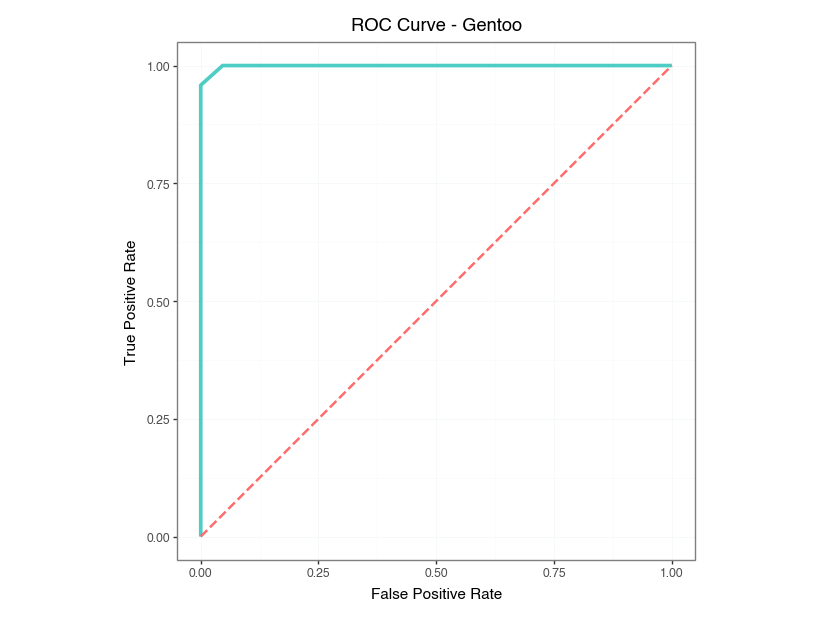

In [61]:
# Species: Gentoo
# Model: DT_3

# Setup
model = model_library["DT_3"]
y_pred_proba = model.predict_proba(X_test)

# Gentoo
y_test_gentoo = (y_test == 'Gentoo').astype(int)
gentoo_index = list(model.classes_).index('Gentoo')
y_pred_proba_gentoo = y_pred_proba[:, gentoo_index]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test_gentoo, y_pred_proba_gentoo)
roc_auc = auc(fpr, tpr)

# Create dataframe
roc_df = pd.DataFrame({
    'FPR': fpr,
    'TPR': tpr
})

# Line for random classifier
diagonal_df = pd.DataFrame({
    'FPR': [0, 1],
    'TPR': [0, 1]
})

# Plot
(p9.ggplot()
    + p9.geom_line(roc_df, p9.aes(x='FPR', y='TPR'), color='#4ECDC4', size=1.5)
    + p9.geom_line(diagonal_df, p9.aes(x='FPR', y='TPR'), color='#FF6B6B', linetype='dashed', size=1)
    + p9.labs(
        title='ROC Curve - Gentoo',
        x='False Positive Rate',
        y='True Positive Rate'
    )
    + p9.theme_bw()
    + p9.theme(
        figure_size=(8, 6),
        panel_background=p9.element_rect(fill='white'),
        panel_grid_major=p9.element_line(color='#f2f7f8', size=0.5)
    )
    + p9.coord_equal()
)